In [238]:
import numpy as np
from scipy.linalg import norm, eig
import time
from geoarray import GeoArray
import scipy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import tkinter
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [209]:
data = GeoArray(r'C:\\Users\\vpatro\\Desktop\\ang20160126\\ang20160126t055327_corr_v2m2_img')
print(data.shape)
print(type(data))

(5618, 704, 425)
<class 'geoarray.baseclasses.GeoArray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


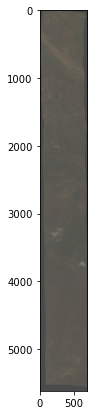

In [210]:
fig = plt.figure(figsize = (12,7))
b = data[:,:,15].copy()
g = data[:,:,35].copy()
r = data[:,:,55].copy()
im = np.dstack((r,g,b))
plt.imshow(im)

z = np.ones((data.shape[0], data.shape[1]))
im = np.dstack((z,z,z))
plt.imshow(im,alpha = 0.3)

In [211]:
def remove_bad_bands(spectra: np.array):
    bands = list(range(1,426))
    bands = np.array(bands)
    deeph2o = np.logical_or(np.logical_and(bands > 181, bands < 224), np.logical_and(bands > 275, bands < 329))
    bad_cal = bands > 418
    bad = np.logical_or(deeph2o, bad_cal)
    spectra[bad] = np.nan

# SavGol smoothening function

def savgol_smoothening(spectra_list:list):
    for spectra in spectra_list:
        noise_peak_1 = spectra[105:120].copy()
        noise_peak_2 = spectra[140:165].copy()
        jagged_peak = spectra[398:419].copy()
        spectra[105:120] = savgol_filter(noise_peak_1, 11,1)
        spectra[140:165] = savgol_filter(noise_peak_2, 21, 1)
        spectra[398:419] = savgol_filter(jagged_peak, 11, 1)
        
                       

In [212]:
# is taking about 2 minutes to chop
start_time = time.time()
data = data[50:5501, 150:601, :] # removing peripheral pushbroom effects
print("--- %s seconds ---" % (time.time() - start_time))

--- 153.6858835220337 seconds ---


Text(0.5, 1.0, 'Covariance Matrix')

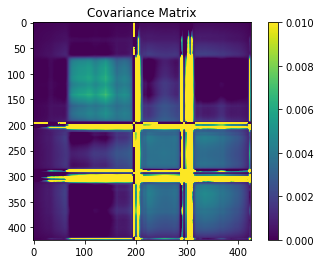

In [239]:
# visualizing covariance matrix - why is it that we only need every 40th?
copied_data = data.copy()
copied_data = copied_data.reshape(data.shape[0]*data.shape[1], data.shape[2])
subsample = np.arange(0,copied_data.shape[0],40) # gathering indices we want
X_sub = copied_data[subsample,:].copy()
Cov = np.cov(X_sub, rowvar = False)

plt.imshow(Cov)
plt.colorbar()
plt.clim(0,0.01)
plt.title('Covariance Matrix')

C:\Users\vpatro\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


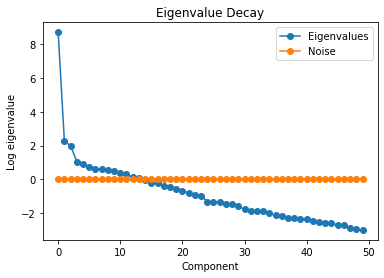

In [247]:
# eigenvector analysis
eigenvalues, eigenvectors = eig(Cov)
noise = np.zeros(50)
plt.plot(np.arange(50), np.log10(eigenvalues[:50]), label = 'Eigenvalues', marker = 'o')
plt.plot(noise, label = 'Noise', marker = 'o')
plt.title('Eigenvalue Decay')
plt.xlabel('Component')
plt.ylabel('Log eigenvalue')
plt.legend()


In [252]:
percent_variance = (eigenvalues[0]/np.sum(eigenvalues)) * 100
print('Variance explained by first PC: ' + str(percent_variance))
percent_variance = (eigenvalues[1]/np.sum(eigenvalues))*100
print('Variance explained by second PC: ' + str(percent_variance))

Variance explained by first PC: (99.99993486280468+0j)
Variance explained by second PC: (3.546805152817201e-05+0j)


In [214]:
svgy_p1 = data[:,:,105:120].copy()
print('shape: ', svgy_p1.shape)
svgy_p1 = svgy_p1.reshape((svgy_p1.shape[0]*svgy_p1.shape[1], svgy_p1.shape[2]))
print('reshapen: ', svgy_p1.shape)
svgy_p2 = data[:,:,140:165].copy()
print('shape: ', svgy_p2.shape)
svgy_p2 = svgy_p2.reshape((svgy_p2.shape[0]*svgy_p2.shape[1], svgy_p2.shape[2]))
print('reshapen: ', svgy_p2.shape)
jagged_peaks = data[:,:,398:419].copy()
print('shape: ', jagged_peaks.shape)
jagged_peaks = jagged_peaks.reshape((jagged_peaks.shape[0]*jagged_peaks.shape[1], jagged_peaks.shape[2]))
print('reshapen: ', jagged_peaks.shape)

shape:  (5451, 451, 15)
reshapen:  (2458401, 15)
shape:  (5451, 451, 25)
reshapen:  (2458401, 25)
shape:  (5451, 451, 21)
reshapen:  (2458401, 21)


Unaltered 1: (2458401, 15)
Post SavGol 1: (2458401, 15)


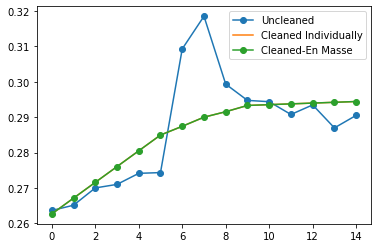

In [215]:
copy_1 = svgy_p1.copy() # duplicate of svgy1
test = svgy_p1[10].copy()
test = savgol_filter(test, 11, 1)
clean_1 = savgol_filter(svgy_p1, 11, 1, axis = 1)
print('Unaltered 1:', copy_1.shape)
print('Post SavGol 1:', svgy_p1.shape)

plt.plot(copy_1[10], label = 'Uncleaned', marker = 'o')
plt.plot(test, label = 'Cleaned Individually')
plt.plot(clean_1[10], label = 'Cleaned-En Masse', marker = 'o')
plt.legend()

Unaltered 2:  (2458401, 25)
Post SavGol 2:  (2458401, 25)


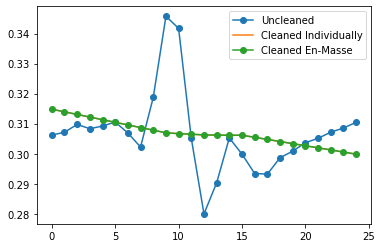

In [216]:
copy_2 = svgy_p2.copy()
test = svgy_p2[30].copy()
test = savgol_filter(test, 19, 1)
clean_2 = savgol_filter(svgy_p2, 19, 1, axis = 1)
print('Unaltered 2: ', copy_2.shape)
print('Post SavGol 2: ', svgy_p2.shape)

plt.plot(copy_2[30], label = 'Uncleaned', marker = 'o')
plt.plot(test, label = 'Cleaned Individually')
plt.plot(clean_2[30], label = 'Cleaned En-Masse', marker = 'o')
plt.legend()

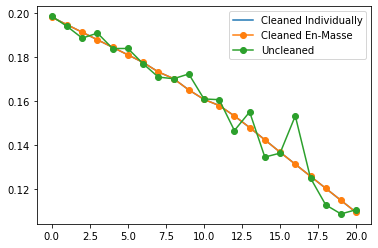

In [217]:
# Jagged peaks at the end bands
copy_3 = jagged_peaks.copy()
test = copy_3[50].copy()
test = savgol_filter(test,11,1)
filtered = savgol_filter(jagged_peaks, 11, 1, axis = 1)

plt.plot(test, label = 'Cleaned Individually')
plt.plot(filtered[50], label = 'Cleaned En-Masse', marker = 'o')
plt.plot(copy_3[50], label = 'Uncleaned', marker = 'o')
plt.legend()

In [218]:
# passing savgol through all 3 peaks peaks

start_time = time.time()
svgy_p1 = savgol_filter(svgy_p1, 11, 1, axis = 1)
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p1.shape)
start_time = time.time()
svgy_p2 = savgol_filter(svgy_p2, 19, 1, axis = 1)
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p2.shape)
start_time = time.time()
svgy_p3 = savgol_filter(jagged_peaks, 11, 1, axis = 1)
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p3.shape)

--- 2.304260730743408 seconds ---
(2458401, 15)
--- 3.7321290969848633 seconds ---
(2458401, 25)
--- 2.467912197113037 seconds ---
(2458401, 21)


In [219]:
svgy1_bands = 15
svgy2_bands = 25
svgy_p3_bands = 21

start_time = time.time()
svgy_p1 = svgy_p1.reshape(data.shape[0], data.shape[1], svgy1_bands)
data[:,:,105:120] = svgy_p1.copy()
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p1.shape)
start_time = time.time()
svgy_p2 = svgy_p2.reshape(data.shape[0], data.shape[1], svgy2_bands)
data[:,:,140:165] = svgy_p2.copy()
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p2.shape)
start_time = time.time()
svgy_p3 = svgy_p3.reshape((data.shape[0], data.shape[1], svgy_p3_bands))
data[:,:,398:419] = svgy_p3.copy()
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p3.shape)

--- 0.21849703788757324 seconds ---
(5451, 451, 15)
--- 0.3914022445678711 seconds ---
(5451, 451, 25)
--- 0.3616015911102295 seconds ---
(5451, 451, 21)


In [220]:
data.shape

(5451, 451, 425)

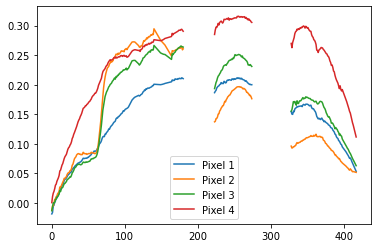

In [222]:
# checking to see if the cleaning worked
for i in range(4):
    spectra = data[np.random.randint(1,5000),np.random.randint(1,400),:].copy()
    remove_bad_bands(spectra)
    plt.plot(spectra, label = 'Pixel ' + str(i+1))
plt.legend()


In [223]:
# reshape array
spectra_list = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

In [224]:
# clustering takes a little over 3 min
start_time = time.time()
seed = 8
kmeans_4 = KMeans(init='k-means++', n_clusters = 4, n_init=10, random_state=seed).fit(spectra_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 222.83230113983154 seconds ---


In [225]:
print(type(kmeans_4.cluster_centers_))
print(type(kmeans_4.cluster_centers_[0]))
print(kmeans_4.cluster_centers_[0].shape)
means_4 = kmeans_4.cluster_centers_
print(means.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(425,)
(4, 425)


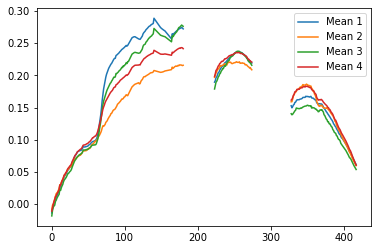

In [226]:
# perhaps I should remove the bad bands before clustering?
for i in range(means_4.shape[0]):
    remove_bad_bands(means_4[i])
    plt.plot(means_4[i], label = 'Mean ' + str(i+1))
plt.legend()

In [227]:
Z_4 = kmeans_4.predict(spectra_list)

In [228]:
clusterCount_4 = np.bincount(kmeans_4.labels_)
print(clusterCount_4)

[2458387       2       2      10]


In [229]:
spectra_list.shape

(2458401, 425)

In [230]:
# clustering takes a little over 2 min
start_time = time.time()
seed = 8
kmeans_2 = KMeans(init='k-means++', n_clusters = 2, n_init=10, random_state=seed).fit(spectra_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 119.3509910106659 seconds ---


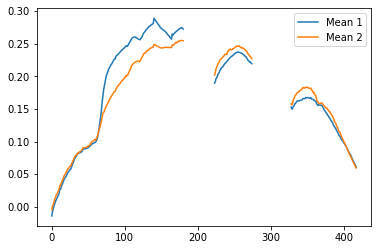

In [231]:
means_2 = kmeans_2.cluster_centers_
for i in range(means_2.shape[0]):
    remove_bad_bands(means_2[i])
    plt.plot(means_2[i], label = 'Mean ' + str(i+1))
plt.legend()

In [232]:
Z_2 = kmeans_2.predict(spectra_list)
clusterCount_2 = np.bincount(kmeans_2.labels_)
print(clusterCount_2)

[2458398       3]


In [233]:
spectra_list.shape

(2458401, 425)

Text(0.5, 1.0, 'K Means: k = 2 -- Cluster 0 Covariance')

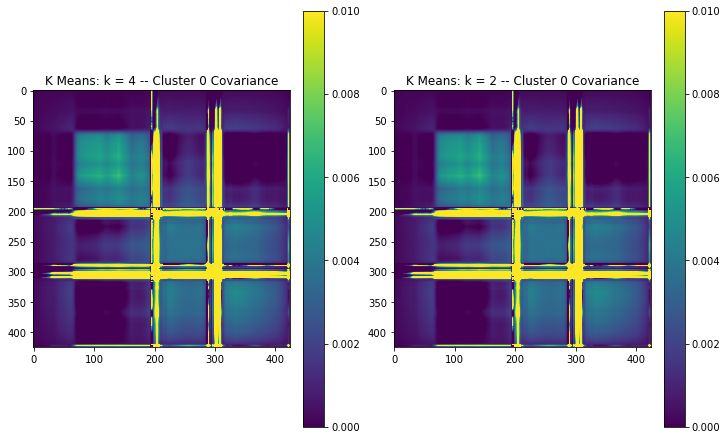

In [234]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,6), constrained_layout = True)
gs = fig.add_gridspec()
C = np.cov(spectra_list[Z_4 == 0, :], rowvar = False)
im = axs[0].imshow(C)
plt.colorbar(im, ax = axs[0])
im.set_clim(0,0.01)
axs[0].set_title('K Means: k = 4 -- Cluster 0 Covariance')
C = np.cov(spectra_list[Z_2 == 0, :], rowvar = False)
im = axs[1].imshow(C)
plt.colorbar(im, ax = axs[1])
im.set_clim(0,0.01)
axs[1].set_title('K Means: k = 2 -- Cluster 0 Covariance')




In [235]:
spectra_list.shape

(2458401, 425)

C:\Users\vpatro\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\vpatro\Anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\vpatro\AppData\Local\Temp\1\ipykernel_24036\95244881.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice
  C = np.cov(spectra_list[Z == 1, :], rowvar = False)
C:\Users\vpatro\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\vpatro\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


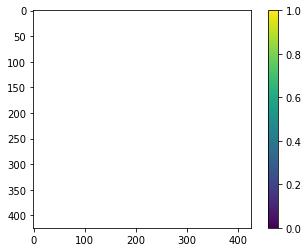

In [236]:
C = np.cov(spectra_list[Z == 1, :], rowvar = False)
plt.imshow(C)
plt.colorbar()
plt.clim(0,1)

(2458401, 425)
Iteration: 0
(2458401, 425)
Iteration: 1
(2458401, 425)
Iteration: 2
(2458401, 425)
Iteration: 3


C:\Users\vpatro\AppData\Local\Temp\1\ipykernel_24036\4135892958.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  C = np.cov(spectra_list[Z == i,:], rowvar = False)


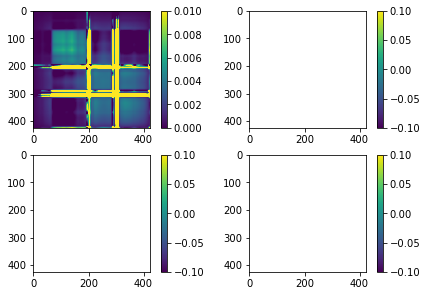

In [237]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (6,4), constrained_layout = True)
gs = fig.add_gridspec()
for i in range(means.shape[0]):
    print(spectra_list.shape)
    C = np.cov(spectra_list[Z == i,:], rowvar = False)
    if i == 0:
        im = axs[0,0].imshow(C)
        plt.colorbar(im, ax = axs[0,0])
        im.set_clim(0,0.01)
    if i == 1:
        im = axs[0,1].imshow(C)
        plt.colorbar(im, ax = axs[0,1])
    if i == 2:
        im = axs[1,0].imshow(C)
        plt.colorbar(im, ax = axs[1,0])
    if i == 3:
        im = axs[1,1].imshow(C)
        plt.colorbar(im, ax = axs[1,1])  
    print('Iteration: ' + str(i))
        
        